## Master of Applied Data Science
### University of Michigan - School of Information
### Capstone Project - Rapid Labeling of Text Corpus Using Information Retrieval Techniques
### Fall 2021
#### Team Members: 
Chloe Zhang ([chloexyz@umich.edu](chloexyz@umich.edu)), 
Michael Penrose ([penrosem@umich.edu](penrosem@umich.edu)), 
Carlo Tak ([carlotak@umich.edu](carlotak@umich.edu))

### Experiment Flow

class label > count vectorizer > unigrams > feature selection > 100 features > PyCaret

### Purpose

This notebook investigates how well a classifier can predict the **event type (i.e. 'earthquake', 'fire', 'flood', 'hurricane)** of the Tweets in the [Disaster tweets dataset](https://crisisnlp.qcri.org/humaid_dataset.html#).

This classifier is to be used as a baseline of classification performance. Two things are investigated:
- Is it possible to build a reasonable 'good' classifier of these tweets at all
- If it is possible to build a classifier how well does the classifier perform using all of the labels from the training data

If it is possible to build a classifier using all of the labels in the training dataset then it should be possible to implement a method for rapidly labeling the corpus of texts in the dataset. Here we think of rapid labeling as any process that does not require the user to label each text in the corpus, one at a time.

To measure the performance of the classifier we use a metric called the Area Under the Curve (AUC). This metric was used because we believe it is a good metric for the preliminary work in this project. If a specific goal emerges later that requires a different metric, then the appropriate metric can be used at that time. The consequence of false positives (texts classified as having a certain label, but are not that label) and false negatives should be considered. For example, a metric like precision can be used to minimize false positives. The AUC metric provides a value between zero and one, with a higher number indicating better classification performance. 


### Summary

The baseline classifier built using all the labels in the training dataset produced a classifier that had a fairly good AUC score for each of the 4 event type labels (i.e. earthquake, fire, flood, hurricane). All the AUC scores were above 0.98.

A simple vectorization (of texts) approach was implemented because we wanted the baseline classifier to be a basic solution – our feeling was that more complex techniques could be implemented at a later stage. A [count vectorizer]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (with default settings) was used to convert the texts. The number of dimensions (features) was also reduced using feature selection ([SelectKBest]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)). This was to improve computational times – fewer dimensions means that there are fewer data to process. Also, this was a simpler method to implement than other techniques like removing stopwords, adjusting parameters like ‘stop_words’, ‘ngram_range’, ‘max_df’, ‘min_df’, and ‘max_features’.  The complexity of the classifier could be adjusted if required, but this simple implementation produced good results.

This notebook reduced the number of features to 100.

The feature importances were extracted from the classifier, to see if they made sense. This sense check was important because we made several assumptions in building this classifier, that had to be validated. For example, when the text was vectorized we used a simple approach that just counted the individual words (tokens) – are more complex classifier might use bi-grams (two words per feature), this would have had the advantage of preserving features like ‘’.

Examining the top features
 



In [1]:
# ! pip freeze > requirements.txt 

In [2]:
from utilities import dt_utilities as utils
from datetime import datetime

In [3]:
start_time = datetime.now()
start_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/04 09:45:55'

In [4]:
consolidated_disaster_tweet_data_df = \
    utils.get_consolidated_disaster_tweet_data(root_directory="data/",
                                               event_type_directory="HumAID_data_event_type",
                                               events_set_directories=["HumAID_data_events_set1_47K",
                                                                       "HumAID_data_events_set2_29K"],
                                               include_meta_data=True)

In [5]:
consolidated_disaster_tweet_data_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798262465234542592,sympathy_and_support,earthquake,dev,RT @MissEarth: New Zealand need our prayers af...
1,771464543796985856,caution_and_advice,earthquake,dev,"@johnaglass65 @gordonluke Ah, woke up to a nig..."
2,797835622471733248,requests_or_urgent_needs,earthquake,dev,RT @terremotocentro: #eqnz if you need a tool ...
3,798021801540321280,other_relevant_information,earthquake,dev,RT @BarristerNZ: My son (4) has drawn a pictur...
4,798727277794033664,infrastructure_and_utility_damage,earthquake,dev,Due to earthquake damage our Defence Force is ...
...,...,...,...,...,...
76479,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
76480,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
76481,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
76482,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [6]:
train_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="train"].reset_index(drop=True)
train_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798064896545996801,other_relevant_information,earthquake,train,I feel a little uneasy about the idea of work ...
1,797913886527602688,caution_and_advice,earthquake,train,#eqnz Interislander ferry docking aborted afte...
2,797867944546025472,other_relevant_information,earthquake,train,Much of New Zealand felt the earthquake after ...
3,797958935126773760,sympathy_and_support,earthquake,train,"Noticing a lot of aftershocks on eqnz site, bu..."
4,797813020567056386,infrastructure_and_utility_damage,earthquake,train,"RT @E2NZ: Mike Clements, NZ police, says obvio..."
...,...,...,...,...,...
53526,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
53527,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
53528,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
53529,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [7]:
test_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="test"].reset_index(drop=True)

In [8]:
dev_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="dev"].reset_index(drop=True)

In [9]:
train_df.groupby(["event_type"]).size().reset_index().rename(columns={0: "Count"}).sort_values("Count", ascending=False)

,event_type,Count
3,hurricane,31674
2,flood,7815
1,fire,7792
0,earthquake,6250


In [10]:
train_df.groupby(["class_label"]).size().reset_index().rename(columns={0: "Count"}).sort_values("Count", ascending=False)

,class_label,Count
8,rescue_volunteering_or_donation_effort,14891
6,other_relevant_information,8501
9,sympathy_and_support,6250
2,infrastructure_and_utility_damage,5715
3,injured_or_dead_people,5110
5,not_humanitarian,4407
0,caution_and_advice,3774
1,displaced_people_and_evacuations,2800
7,requests_or_urgent_needs,1833
4,missing_or_found_people,250


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.sparse import coo_matrix, hstack
import scipy.sparse
import numpy as np
from collections import Counter

In [12]:
num_features = 100
target_column = "class_label"
# vectorizer = TfidfVectorizer(max_features=num_features)
# count_vectorizer = CountVectorizer(max_features=num_features)

vectorizer = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("reduce", SelectKBest(score_func=f_classif, k=num_features)), # chi2, f_classif
])

In [13]:
vectorizer.fit(train_df["tweet_text"], train_df[target_column])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('reduce', SelectKBest(k=100))])

In [14]:
def vectorized_tweet_data(fitted_vectorizer, source_df, text_column, target_column, 
                          vectorizer_name="vectorizer", reducer_name="reduce"):
    vectorized_data = fitted_vectorizer.transform(source_df[text_column])
    
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(vectorized_data)
    
    all_feature_names = fitted_vectorizer.named_steps[vectorizer_name].get_feature_names()
    support = vectorizer.named_steps[reducer_name].get_support()
    feature_names = np.array(all_feature_names)[support]
    vectorized_df.columns = feature_names

    vectorized_df = vectorized_df.sparse.to_dense()

    # vectorized_df = vectorized_df.apply(pd.to_numeric)
    vectorized_df = vectorized_df.astype(float)

    vectorized_df["tweet_id"] = source_df["tweet_id"]
    vectorized_df["tweet_text"] = source_df["tweet_text"]
    vectorized_df[target_column] = source_df[target_column]

    return vectorized_df

In [15]:
train_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=train_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column, 
                                                       vectorizer_name="vectorizer", 
                                                       reducer_name="reduce")
train_vectorized_event_type_df

,affected,all,allah,and,at,by,california,confirmed,damage,damaged,dead,deadliest,death,deaths,declared,destroyed,died,displaced,donate,donated,donating,donation,donations,dorian,earthquake,eddison,edt,efforts,ellicott,emergency,evacuate,evacuated,evacuating,evacuation,evacuations,evacuees,everyone,fires,flash,flooding,florence,food,for,fund,guardsman,heart,help,hermond,hurricane,injured,irma,issued,kerala,keralafloodrelief,keralafloods,killed,kills,least,mandatory,maryland,missing,my,need,needed,needs,ordered,orders,our,people,please,pray,prayers,praying,realdonaldtrump,relief,rescue,risen,rises,safe,stay,storm,support,swept,those,thoughts,to,toll,tornado,tropical,trump,tsunami,urgent,victims,volunteers,warning,warnings,water,wildfires,winds,you,tweet_id,tweet_text,class_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798064896545996801,I feel a little uneasy about the idea of work ...,other_relevant_information
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797913886527602688,#eqnz Interislander ferry docking aborted afte...,caution_and_advice
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797867944546025472,Much of New Zealand felt the earthquake after ...,other_relevant_information
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797958935126773760,"Noticing a lot of aftershocks on eqnz site, bu...",sympathy_and_support
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797813020567056386,"RT @E2NZ: Mike Clements, NZ police, says obvio...",infrastructure_and_utility_damage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [16]:
test_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=test_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column)

In [17]:
dev_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=dev_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column)

In [18]:
import pycaret.classification as pc_class
RND_SEED = 39674
N_JOBS = 2
# include_models = ["nb", "lr", "gbc", "lightgbm"] # , "xgboost"
exclude_models = ["knn", "svm", "ridge"]

numeric_features_adj = train_vectorized_event_type_df.columns.tolist()
numeric_features_adj = [x for x in numeric_features_adj if x not in [target_column, "tweet_id", "tweet_text"]]
# numeric_features_adj

In [19]:
exp_00 = pc_class.setup(train_vectorized_event_type_df, 
                        
                        numeric_features=numeric_features_adj,
#                         categorical_features=categorical_features,


                        silent=True,
                        verbose=False,

                        ignore_features=["tweet_id", "tweet_text"],
                        target=target_column, # "event_type", # "class_label"
                        session_id=RND_SEED,

                        n_jobs=N_JOBS)

INFO - PyCaret Supervised Module
INFO - ML Usecase: classification
INFO - version 2.3.0
INFO - Initializing setup()
INFO - setup(display=None, profile_kwargs=None, profile=False, verbose=False, silent=True, log_data=False, log_profile=False, log_plots=False, experiment_name=None, log_experiment=False, session_id=39674, html=True, custom_pipeline=None, use_gpu=False, n_jobs=2, fold_groups=None, fold_shuffle=False, fold=10, fold_strategy=stratifiedkfold, data_split_stratify=False, data_split_shuffle=True, transform_target_method=box-cox, transform_target=False, fix_imbalance_method=None, fix_imbalance=False, interaction_threshold=0.01, feature_ratio=False, feature_interaction=False, feature_selection_method=classic, feature_selection_threshold=0.8, feature_selection=False, group_names=None, group_features=None, polynomial_threshold=0.1, trigonometry_features=False, polynomial_degree=2, polynomial_features=False, cluster_iter=20, create_clusters=False, remove_perfect_collinearity=True, mu

In [20]:
best_model = pc_class.compare_models(sort="AUC",
#                                      include=include_models,
                                     exclude=exclude_models,
                                     turbo=True
                                       )
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6808,0.9233,0.6359,0.6917,0.6763,0.6191,0.6226,124.4660
lightgbm,Light Gradient Boosting Machine,0.6796,0.9230,0.6377,0.6875,0.6751,0.6183,0.6213,2.3680
xgboost,Extreme Gradient Boosting,0.6790,0.9222,0.6362,0.6903,0.6741,0.6173,0.6210,38.4850
lr,Logistic Regression,0.6760,0.9191,0.6293,0.6883,0.6696,0.6131,0.6174,6.5430
gbc,Gradient Boosting Classifier,0.6791,0.9181,0.6352,0.6940,0.6727,0.6171,0.6217,30.0940
rf,Random Forest Classifier,0.6525,0.8964,0.6088,0.6530,0.6490,0.5865,0.5878,2.9780
lda,Linear Discriminant Analysis,0.6544,0.8949,0.6669,0.6913,0.6582,0.5929,0.5983,0.7440
et,Extra Trees Classifier,0.6469,0.8775,0.6126,0.6481,0.6450,0.5809,0.5818,5.8080
dt,Decision Tree Classifier,0.5949,0.7938,0.5675,0.6080,0.5995,0.5225,0.5234,0.3690
nb,Naive Bayes,0.2620,0.7794,0.4288,0.6487,0.3033,0.2268,0.2717,0.1240


INFO - create_model_container: 12
INFO - master_model_container: 12
INFO - display_container: 2
INFO - <catboost.core.CatBoostClassifier object at 0x0000021E2B6192E8>
INFO - compare_models() succesfully completed......................................


In [21]:
finalized_model = pc_class.finalize_model(best_model)

INFO - Initializing finalize_model()
INFO - finalize_model(display=None, model_only=True, groups=None, fit_kwargs=None, estimator=<catboost.core.CatBoostClassifier object at 0x0000021E2B6192E8>)
INFO - Finalizing <catboost.core.CatBoostClassifier object at 0x0000021E2B6192E8>
INFO - Initializing create_model()
INFO - create_model(kwargs={}, display=None, metrics=None, system=False, verbose=False, refit=True, groups=None, fit_kwargs={}, predict=True, cross_validation=True, round=4, fold=None, estimator=<catboost.core.CatBoostClassifier object at 0x0000021E2B6192E8>)
INFO - Checking exceptions
INFO - Importing libraries
INFO - Copying training dataset
INFO - Defining folds
INFO - Declaring metric variables
INFO - Importing untrained model
INFO - Declaring custom model
INFO - CatBoost Classifier Imported succesfully
INFO - Starting cross validation
INFO - Cross validating with StratifiedKFold(n_splits=10, random_state=None, shuffle=False), n_jobs=2
INFO - Calculating mean and std
INFO - C

In [22]:
y_train = pc_class.get_config("y_train")

INFO - Initializing get_config()
INFO - get_config(variable=y_train)
INFO - Global variable: y_train returned as 25392    0
16418    8
15097    8
35125    6
2652     3
        ..
13558    1
35536    6
40614    6
27883    0
39469    6
Name: class_label, Length: 37471, dtype: int32
INFO - get_config() succesfully completed......................................


In [23]:
y_test = pc_class.get_config("y_test")

INFO - Initializing get_config()
INFO - get_config(variable=y_test)
INFO - Global variable: y_test returned as 20453    8
892      6
43651    8
39427    1
13870    8
        ..
17174    8
4967     5
34935    3
11209    6
47010    8
Name: class_label, Length: 16060, dtype: int64
INFO - get_config() succesfully completed......................................


In [24]:
y = pc_class.get_config("y")

INFO - Initializing get_config()
INFO - get_config(variable=y)
INFO - Global variable: y returned as 0        6
1        0
2        6
3        9
4        2
        ..
53526    2
53527    5
53528    6
53529    9
53530    2
Name: class_label, Length: 53531, dtype: int64
INFO - get_config() succesfully completed......................................


In [25]:
original_labels = train_df[target_column]

In [26]:
Counter(original_labels)

Counter({'other_relevant_information': 8501,
         'caution_and_advice': 3774,
         'sympathy_and_support': 6250,
         'infrastructure_and_utility_damage': 5715,
         'rescue_volunteering_or_donation_effort': 14891,
         'displaced_people_and_evacuations': 2800,
         'not_humanitarian': 4407,
         'requests_or_urgent_needs': 1833,
         'injured_or_dead_people': 5110,
         'missing_or_found_people': 250})

In [27]:
labels_map = dict(zip(y, original_labels))
labels_map

{6: 'other_relevant_information',
 0: 'caution_and_advice',
 9: 'sympathy_and_support',
 2: 'infrastructure_and_utility_damage',
 8: 'rescue_volunteering_or_donation_effort',
 1: 'displaced_people_and_evacuations',
 5: 'not_humanitarian',
 7: 'requests_or_urgent_needs',
 3: 'injured_or_dead_people',
 4: 'missing_or_found_people'}

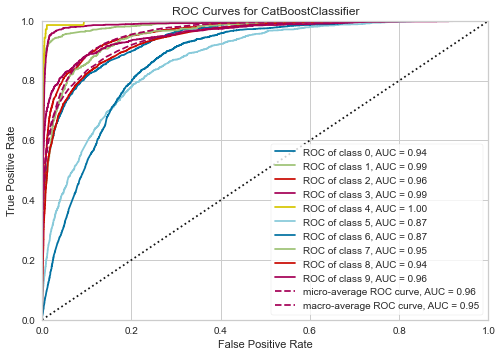

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [28]:
try:
    pc_class.plot_model(finalized_model, "auc")
except:
    print(f"Could not plot model.")

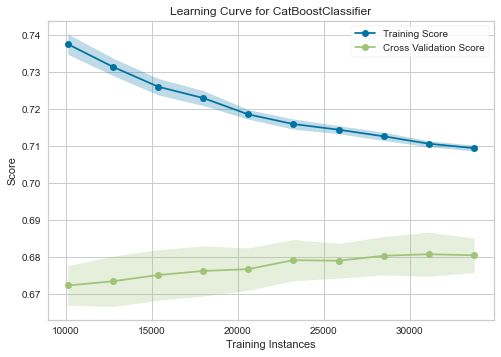

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [29]:
try:
    pc_class.plot_model(finalized_model, "learning")
except:
    print(f"Could not plot model.")

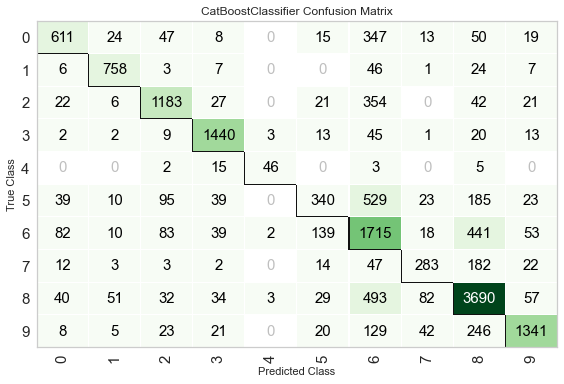

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [30]:
try:
    pc_class.plot_model(finalized_model, "confusion_matrix")
except:
    print(f"Could not plot model.")

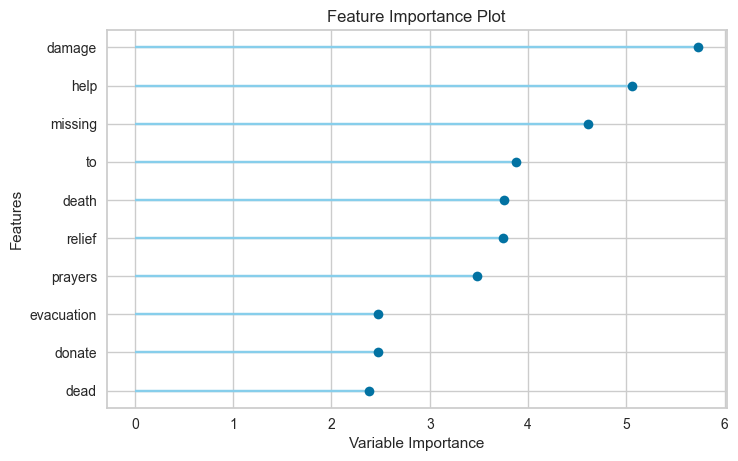

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [31]:
try:
    pc_class.plot_model(finalized_model, "feature")
except:
    print(f"Could not plot model.")

In [32]:
predictions_train = pc_class.predict_model(finalized_model)
predictions_train

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=<catboost.core.CatBoostClassifier object at 0x0000021E2B5DEF98>)
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7103,0.9368,0.6689,0.7236,0.7067,0.6536,0.6570


,affected,all,allah,and,at,by,california,confirmed,damage,damaged,...,volunteers,warning,warnings,water,wildfires,winds,you,class_label,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.4707
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other_relevant_information,caution_and_advice,0.3570
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.9502
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,displaced_people_and_evacuations,other_relevant_information,0.5401
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.7309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16055,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.9306
16056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,not_humanitarian,other_relevant_information,0.2922
16057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,injured_or_dead_people,injured_or_dead_people,0.9626
16058,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,other_relevant_information,other_relevant_information,0.3775


In [33]:
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_columns', 500)

In [34]:
predictions_train_with_text = \
    pd.concat([
                
                predictions_train,
                train_df.iloc[y_test.index.to_list()][["tweet_text"]].reset_index(drop=True),
              ], axis=1)

predictions_train_with_text.head(5)

,affected,all,allah,and,at,by,california,confirmed,damage,damaged,dead,deadliest,death,deaths,declared,destroyed,died,displaced,donate,donated,donating,donation,donations,dorian,earthquake,eddison,edt,efforts,ellicott,emergency,evacuate,evacuated,evacuating,evacuation,evacuations,evacuees,everyone,fires,flash,flooding,florence,food,for,fund,guardsman,heart,help,hermond,hurricane,injured,irma,issued,kerala,keralafloodrelief,keralafloods,killed,kills,least,mandatory,maryland,missing,my,need,needed,needs,ordered,orders,our,people,please,pray,prayers,praying,realdonaldtrump,relief,rescue,risen,rises,safe,stay,storm,support,swept,those,thoughts,to,toll,tornado,tropical,trump,tsunami,urgent,victims,volunteers,warning,warnings,water,wildfires,winds,you,class_label,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.4707,Low income flood victims being offered food benefits. -KFOR News
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other_relevant_information,caution_and_advice,0.3570,"NZStuff: No tsunami threat to New Zealand after 7.3 magnitude earthquake hits off the coast of Fukushima, Japan"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.9502,"Yesterday afternoon, VSL successfully handed over items donated to the victims of the mudslide via our website. Thx!"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,displaced_people_and_evacuations,other_relevant_information,0.5401,"22,000 packed into shelters in Lee County, Florida ahead of Hurricane Irma"
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,0.7309,"We’re joining hundreds of fellow breweries on #GivingTuesday in brewing Resilience IPA, a beer to support @SierraNevada and their efforts to raise funds for those affected by the Camp Fire in CA."


In [35]:
predictions_train_with_text_misclassification = \
    predictions_train_with_text[predictions_train_with_text[target_column]!=predictions_train_with_text["Label"]].reset_index(drop=True)

predictions_train_with_text_misclassification.head(5)

,affected,all,allah,and,at,by,california,confirmed,damage,damaged,dead,deadliest,death,deaths,declared,destroyed,died,displaced,donate,donated,donating,donation,donations,dorian,earthquake,eddison,edt,efforts,ellicott,emergency,evacuate,evacuated,evacuating,evacuation,evacuations,evacuees,everyone,fires,flash,flooding,florence,food,for,fund,guardsman,heart,help,hermond,hurricane,injured,irma,issued,kerala,keralafloodrelief,keralafloods,killed,kills,least,mandatory,maryland,missing,my,need,needed,needs,ordered,orders,our,people,please,pray,prayers,praying,realdonaldtrump,relief,rescue,risen,rises,safe,stay,storm,support,swept,those,thoughts,to,toll,tornado,tropical,trump,tsunami,urgent,victims,volunteers,warning,warnings,water,wildfires,winds,you,class_label,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other_relevant_information,caution_and_advice,0.3570,"NZStuff: No tsunami threat to New Zealand after 7.3 magnitude earthquake hits off the coast of Fukushima, Japan"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,displaced_people_and_evacuations,other_relevant_information,0.5401,"22,000 packed into shelters in Lee County, Florida ahead of Hurricane Irma"
2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rescue_volunteering_or_donation_effort,other_relevant_information,0.4007,"In #Mozambique, WHO are building up a #CycloneIdai surge team of over 40 staff from across the Organization, with expertise in coordination, planning, logistics, epidemiology, and outbreak prevention and response."
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other_relevant_information,injured_or_dead_people,0.7376,"In cyclone-hit Mozambique, a quest to find and name the dead. Some of them wore the uniforms of neighboring Zimbabwe’s security forces, having been swept down mountainsides some 100 kilometers away by the raging waters. #CycloneIdai"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other_relevant_information,rescue_volunteering_or_donation_effort,0.3588,So Shashi Tharoor &amp; others laughing away while people of Kerala reel under worst ever Floods. #KeralaFloods is a joke for them


In [36]:
predictions_train_with_text_misclassification.sort_values(["Score"], ascending=True).head(5)

,affected,all,allah,and,at,by,california,confirmed,damage,damaged,dead,deadliest,death,deaths,declared,destroyed,died,displaced,donate,donated,donating,donation,donations,dorian,earthquake,eddison,edt,efforts,ellicott,emergency,evacuate,evacuated,evacuating,evacuation,evacuations,evacuees,everyone,fires,flash,flooding,florence,food,for,fund,guardsman,heart,help,hermond,hurricane,injured,irma,issued,kerala,keralafloodrelief,keralafloods,killed,kills,least,mandatory,maryland,missing,my,need,needed,needs,ordered,orders,our,people,please,pray,prayers,praying,realdonaldtrump,relief,rescue,risen,rises,safe,stay,storm,support,swept,those,thoughts,to,toll,tornado,tropical,trump,tsunami,urgent,victims,volunteers,warning,warnings,water,wildfires,winds,you,class_label,Label,Score,tweet_text
3899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,not_humanitarian,rescue_volunteering_or_donation_effort,0.2233,"Just wow, a wow. Do we still need reasons for #earthquake ?"
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,requests_or_urgent_needs,rescue_volunteering_or_donation_effort,0.2235,"If you have extra supplies please let us know Let Your Voice Be Heard, Inc. will be collecting supplies for #BahamasRelief for #HurricaneDorian #Share"
3334,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,sympathy_and_support,rescue_volunteering_or_donation_effort,0.2235,RT @marcorubio: #PuertoRico we are with you. We will do all we can to make sure you receive the help you need as soon as possible. #Hurrica
2017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,requests_or_urgent_needs,caution_and_advice,0.2256,"Since you’re here, Floridians, and shopping’s on the mind, could you please give those of us on the (northern) East Coast your expert ideas for non perishable but delicious food items for storms? #dorian #dorianhurricane #Dorianflorida #dorianhurricane2019 #floridahurricane"
2888,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,not_humanitarian,other_relevant_information,0.2283,It is so disgusting you do kot need to drag your cheap politics in every scenario. Shameful remarks on #earthquake by #firdousashiqawan


In [37]:
predictions_test = pc_class.predict_model(finalized_model, data=test_vectorized_event_type_df)
predictions_test

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=<catboost.core.CatBoostClassifier object at 0x0000021E2B5DEF98>)
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,affected,all,allah,and,at,by,california,confirmed,damage,damaged,dead,deadliest,death,deaths,declared,destroyed,died,displaced,donate,donated,donating,donation,donations,dorian,earthquake,eddison,edt,efforts,ellicott,emergency,evacuate,evacuated,evacuating,evacuation,evacuations,evacuees,everyone,fires,flash,flooding,florence,food,for,fund,guardsman,heart,help,hermond,hurricane,injured,irma,issued,kerala,keralafloodrelief,keralafloods,killed,kills,least,mandatory,maryland,missing,my,need,needed,needs,ordered,orders,our,people,please,pray,prayers,praying,realdonaldtrump,relief,rescue,risen,rises,safe,stay,storm,support,swept,those,thoughts,to,toll,tornado,tropical,trump,tsunami,urgent,victims,volunteers,warning,warnings,water,wildfires,winds,you,tweet_id,tweet_text,class_label,Label,Score
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798274825441538048,The earthquake in New Zealand was massive. Billions of dollars of damage. And it was followed by a storm.,infrastructure_and_utility_damage,infrastructure_and_utility_damage,0.8043
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the quake damage to this building. Keep well clear!,infrastructure_and_utility_damage,infrastructure_and_utility_damage,0.8181
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF NZ?! They seem to be happening an awful lot. Stay safe everyone xx #eqnz,sympathy_and_support,sympathy_and_support,0.6013
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,798434862830993408,"When theres an actual earthquake, landslide and severe flooding during your driving test and you still pass #eqnz #Wellington @NZTAWgtn",not_humanitarian,other_relevant_information,0.4062
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, be safe people, move to higher ground! #eqnz",caution_and_advice,caution_and_advice,0.8619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [38]:
end_time = datetime.now()
end_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/04 13:00:43'

In [39]:
duration = end_time - start_time
print("duration :", duration)

duration : 3:14:47.792311
